##Libraries&Load Data


In [38]:
pip install -U pymoo

In [39]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.asf import ASF
from pymoo.mcdm.pseudo_weights import PseudoWeights

import pandas as pd
import numpy as np
import random
import tensorflow as tf
import joblib
import pickle
from scipy.optimize import minimize, LinearConstraint

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
path = '/content/drive/MyDrive/Tesi/data/Dati/'
data_load_path = path + 'data/load/data_load.xlsx'
data_prod_path = path + 'data/production/data_production.xlsx'
data_load = pd.read_excel(data_load_path, decimal=',')
data_prod = pd.read_excel(data_prod_path, decimal=',')
data_load = data_load.set_index("datetime")
data_prod = data_prod.set_index("datetime")

def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
      row = [a for a in df_as_np[i : i + window_size]]
      X.append(row)
      label = df_as_np[i + window_size]
      y.append(label)
  return np.array(X), np.array(y)

win_size = 3
X_load, y_load = df_to_X_y(data_load, win_size)
X_prod, y_prod = df_to_X_y(data_prod, win_size)

y_load = y_load.flatten()
y_prod = y_prod.flatten()

In [42]:
# Load the models

model_load_path = path + 'models/load/gru_model.keras'
model_load_gru = tf.keras.models.load_model(model_load_path)
model_load_path = path + 'models/production/lstm_model.keras'
model_prod_lstm = tf.keras.models.load_model(model_load_path)

# Make predictions using the loaded model

load = data_load.iloc[3:]
load['pred'] = model_load_gru.predict(X_load).flatten()
load['pred'] = load['pred'].abs()

# Make predictions using the loaded model

prod = data_prod.iloc[3:]
prod['pred'] = model_prod_lstm.predict(X_load).flatten()
prod['pred'] = prod['pred'].abs()

274/274 [==============================] - 1s 3ms/step


<ipython-input-42-046916bdbe62>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load['pred'] = model_load_gru.predict(X_load).flatten()
<ipython-input-42-046916bdbe62>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  load['pred'] = load['pred'].abs()


274/274 [==============================] - 1s 2ms/step


<ipython-input-42-046916bdbe62>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod['pred'] = model_prod_lstm.predict(X_load).flatten()
<ipython-input-42-046916bdbe62>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod['pred'] = prod['pred'].abs()


##Data Generation

In [43]:
n_prosumers = 2
n_consumers = 2
C_spot = 0.174
C_sell = 0.2
omega_t = [str(ts) for ts in load.index]
omega_alpha = n_prosumers + n_consumers
D = 10
C = 10

In [44]:
# Generation of data

tot_load_m = []
tot_prod_m = []

for t in range(len(omega_t)):
    p = prod.loc[omega_t[t],'pred']
    l = load.loc[omega_t[t], 'pred']
    tot_load = []
    tot_prod = []
    for i in range(n_prosumers):
        if (p > 0):
          deviation = random.uniform(-0.02, 0.02)
          pi = p + deviation

          deviation = random.uniform(-0.02, 0.02)
          ci = l + deviation

          if pi > ci:
              tot_load.append(0)
              tot_prod.append(pi-ci)
          elif pi == ci:
              tot_load.append(0)
              tot_prod.append(0)
          else:
              tot_load.append(ci-pi)
              tot_prod.append(0)
        else:
          tot_prod.append(0)
          deviation = random.uniform(-0.02, 0.02)
          ci = l + deviation
          tot_load.append(ci)

    for i in range(n_consumers):
        deviation = random.uniform(-0.02, 0.02)
        ci = l + deviation
        tot_load.append(ci)
        tot_prod.append(0)

    tot_prod_m.append(tot_prod)
    tot_load_m.append(tot_load)


# Optimization problem


In [45]:
I = 0
X = 0
C_LEM = 0
x = (I, X, C_LEM)

In [ ]:
# C_spot * G + (1.05) * C_LEM * I_p2p -  C_sell * E - (0.95) * C_LEM * X_p2p
def objective_function(x):
    I, X, C_LEM = x
    return C_spot * G + (1.05) * C_LEM * I -  C_sell * E - (0.95) * C_LEM * X_p2p

# Constraints
def constraint_1(x):
    I, X, C_LEM = x
    return X_p2p - I_p2p

def constraint_2(x):
    I, X, C_LEM = x
    lhs = G + I_p2p + D + res_pv
    rhs = dem + X_p2p + C + E
    return lhs - rhs

def constraint_3(x):
    I, X, C_LEM = x
    return (I_p2p + G) - dem

def constraint_4(x):
    I, X, C_LEM = x
    return (X_p2p + E) - res_pv

def constraint_5(x):
    I, X, C_LEM = x
    return D - C

def constraint_6(x):
    I, X, C_LEM = x
    return C_spot - C_LEM

bounds = ((0, None), (0, None), (0, None), (0, None), (0, None))
constraints = [{'type': 'eq', 'fun': constraint_1}, {'type': 'ineq', 'fun': constraint_2},
               {'type': 'eq', 'fun': constraint_3}, {'type': 'eq', 'fun': constraint_4},{'type': 'ineq', 'fun': constraint_5}]

In [ ]:
def optimization(t):
    results = pd.DataFrame(columns=['G', 'E', 'I_p2p', 'X_p2p', 'G+I', 'dem', 'E+X', 'res_pv', 'C_LEM'])
    for h in range(omega_alpha):
        initial_guess = [0, 0, 0, 0, 0]
        dem = tot_load_m[t][h]
        res_pv = tot_prod_m[t][h]

        result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints)
        row_values = [result.x[0], result.x[1], result.x[2], result.x[3], result.x[0]+result.x[2], dem, result.x[1]+result.x[3], res_pv, result.x[4]]
        results.loc[len(results)] = row_values
    return results

# Multiobjective optimization

In [ ]:
I = 0
X = 0

In [ ]:
class MyProblem(ElementwiseProblem):

    def __init__(self, additional_args):
        super().__init__(n_var=5,
                         n_obj=2,
                         n_ieq_constr=4,
                         xl=np.array([0, 0, 0, 0, 0]),
                         xu=np.array([5, 5, 5, 5, 5]))
        self.additional_args = additional_args

    # x = (I, X, C_LEM)
    def _evaluate(self, x, out, *args, **kwargs):
        dem, res_pv = self.additional_args

        #    C_spot *      G       + (1.05) * C_LEM * I_p2p - C_sell *            E    - (0.95) * C_LEM * X_p2p
        f1 = C_spot * (dem - x[0]) + (1.05) * x[2]  * x[0]  - C_sell * (res_pv - x[1]) - (0.95) * x[2]  * x[1]
        f2 = -x[1]

        #    X_p2p - I_p2p
        g1 = x[1] - x[0]
        #    G +   I_p2p + D + res_pv - dem + X_p2p + C + E
        g2 = (dem - x[0]) + x[0] + D + res_pv - (dem + x[1] + C + (res_pv - x[1]))
        #    (I_p2p + G) - dem
        g3 = x[0] - dem
        #    (X_p2p + E) - res_pv
        g4 = x[1] - res_pv

        out["F"] = [f1, f2]
        out["G"] = [g1, g2, g3, g4]

def multi_optimization(pop_size, n_offsprings, prob, eta_1, eta_2, termination, dem, res_pv):
    args = (dem, res_pv)
    problem = MyProblem(args)

    algorithm = NSGA2(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=prob, eta=eta_1),
        mutation=PM(eta=eta_2),
        eliminate_duplicates=True
    )

    termination = get_termination("n_gen", termination)

    res = minimize(problem,
                  algorithm,
                  termination,
                  seed=1,
                  return_least_infeasible=True,
                  save_history=False,
                  verbose=False)

    X = res.X
    F = res.F
    fl = F.min(axis=0)
    fu = F.max(axis=0)
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

    fl_2 = nF.min(axis=0)
    fu_2 = nF.max(axis=0)
    weights = np.array([0.5, 0.5])
    decomp = ASF()
    i = decomp.do(nF, 1/weights).argmin()
    i_2 = PseudoWeights(weights).do(nF)
    return X[i]

In [ ]:
results_multiobj = pd.DataFrame(columns=['G', 'E', 'I_p2p', 'X_p2p', 'G+I', 'dem', 'E+X', 'res_pv', 'C_LEM'])
def optimization_2(t):
    for h in range(omega_alpha):
        dem = tot_load_m[t][h]
        res_pv = tot_prod_m[t][h]
        pop_size = 100
        n_offsprings = 50
        prob = 0.9
        eta_1 = 15
        eta_2 = 20
        termination = 100
        result = multi_optimization(pop_size, n_offsprings, prob, eta_1, eta_2, termination, dem, res_pv)
        row_values = [result[0], result[1], result[2], result[3], result[0]+result[2], dem, result[1]+result[3], res_pv, result[4]]
        results_multiobj.loc[len(results_multiobj)] = row_values
    return results

plots

In [ ]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


problem = MyProblem()

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
from pymoo.termination import get_termination

termination = get_termination("n_gen", 40)
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

Best regarding ASF: Point 
i = 31
F = [-0.07195173 -0.04658363]


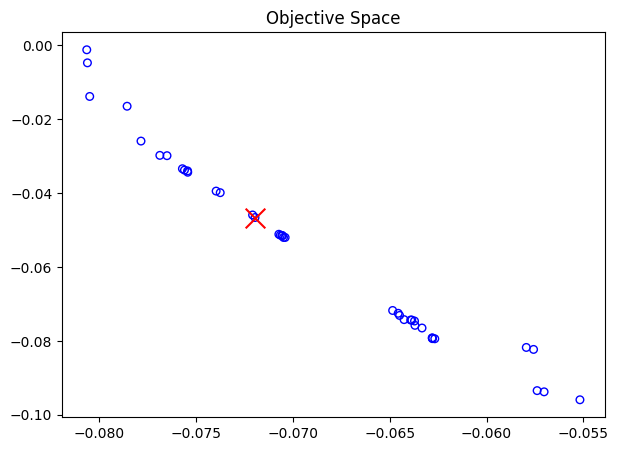

In [ ]:
print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

# Tests


In [ ]:
for t in range(24):
    results = pd.DataFrame(columns=['G', 'E', 'I_p2p', 'X_p2p', 'G+I', 'dem', 'E+X', 'res_pv', 'C_LEM'])
    for h in range(omega_alpha):
        dem = tot_load_m[t][h]
        res_pv = tot_prod_m[t][h]
        initial_guess = [0, 0, 0, 0, 0]

        result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints)
        row_values = [result.x[0], result.x[1], result.x[2], result.x[3], result.x[0]+result.x[2], dem, result.x[1]+result.x[3], res_pv, result.x[4]]
        results.loc[len(results)] = row_values

In [ ]:
results

In [ ]:
t = 0

results_multiobj = pd.DataFrame(columns=['G', 'E', 'I_p2p', 'X_p2p', 'G+I', 'dem', 'E+X', 'res_pv', 'C_LEM'])
for h in range(omega_alpha):
    dem = tot_load_m[t][h]
    res_pv = tot_prod_m[t][h]
    pop_size = 100
    n_offsprings = 50
    prob = 0.9
    eta_1 = 15
    eta_2 = 20
    termination = 100
    result = multi_optimization(pop_size, n_offsprings, prob, eta_1, eta_2, termination, dem, res_pv)
    row_values = [result[0], result[1], result[2], result[3], result[0]+result[2], dem, result[1]+result[3], res_pv, result[4]]
    results_multiobj.loc[len(results_multiobj)] = row_values

In [ ]:
results_multiobj

,G,E,I_p2p,X_p2p,G+I,dem,E+X,res_pv,C_LEM
0,4.655382e-03,1.935724e-15,5.956104e-04,7.512523e-15,5.250993e-03,0.017981,9.448247e-15,0.000000,1.943804
1,3.447486e-03,3.860685e-15,6.493983e-04,8.354157e-15,4.096884e-03,0.025304,1.221484e-14,0.000000,0.432056
2,6.068181e-05,0.000000e+00,1.652598e-04,2.219046e-15,2.259416e-04,0.017198,2.219046e-15,0.000000,4.893436
3,1.663852e-03,3.365737e-13,4.165255e-07,1.809928e-12,1.664268e-03,0.003698,2.146501e-12,0.000000,0.523277
4,3.162805e-10,1.057792e-02,2.599107e-09,2.634676e-06,2.915388e-09,0.000000,1.058056e-02,0.010589,3.016696
5,1.189984e-05,2.936322e-16,5.380018e-03,1.346961e-17,5.391918e-03,0.115030,3.071018e-16,0.000000,3.979537
6,1.591451e-02,3.696094e-15,6.332563e-05,1.289278e-13,1.597784e-02,0.126076,1.326239e-13,0.000000,4.941383
7,9.460516e-04,1.194393e-15,1.730450e-03,9.352100e-16,2.676502e-03,0.106365,2.129603e-15,0.000000,2.590037
8,3.952632e-04,3.048164e-16,1.467445e-03,9.172264e-16,1.862709e-03,0.135026,1.222043e-15,0.000000,3.541568
9,4.248707e-03,1.416720e-16,4.893526e-03,1.019891e-15,9.142233e-03,0.133272,1.161563e-15,0.000000,0.863435


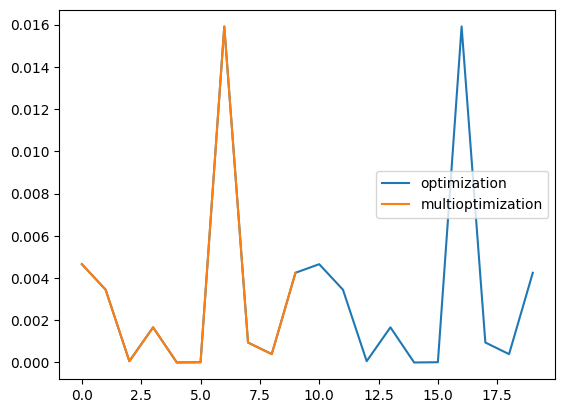

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results['G'], label='optimization')
plt.plot(results_multiobj['G'], label='multioptimization')

plt.legend()
plt.show()

In [34]:
df = pd.DataFrame(columns=['dem', 'res_pv', 'C_spot', 'C_sell'])
for t in range(24):
    for h in range(omega_alpha):
      row_values = [tot_load_m[t][h], tot_prod_m[t][h], C_spot, C_sell]
      df.loc[len(df)] = row_values
variables = pd.DataFrame(columns=['I', 'X','C_LEM'])

# others

In [57]:
def crowding_distance(pop_obj, front_no):
    """
    The crowding distance of each Pareto front
    :param pop_obj: objective vectors
    :param front_no: front numbers
    :return: crowding distance
    """
    n, M = np.shape(pop_obj)
    crowd_dis = np.zeros(n)
    front = np.unique(front_no)
    Fronts = front[front != np.inf]
    for f in range(len(Fronts)):
        Front = np.array([k for k in range(len(front_no)) if front_no[k] == Fronts[f]])
        Fmax = pop_obj[Front, :].max(0)
        Fmin = pop_obj[Front, :].min(0)
        for i in range(M):
            rank = np.argsort(pop_obj[Front, i])
            crowd_dis[Front[rank[0]]] = np.inf
            crowd_dis[Front[rank[-1]]] = np.inf
            for j in range(1, len(Front) - 1):
                crowd_dis[Front[rank[j]]] = crowd_dis[Front[rank[j]]] + (pop_obj[(Front[rank[j + 1]], i)] - pop_obj[
                    (Front[rank[j - 1]], i)]) / (Fmax[i] - Fmin[i])
    return crowd_dis

In [58]:
def nd_sort(pop_obj, n_sort):
    """
    :rtype:
    :param n_sort:
    :param pop_obj: objective vectors
    :return: [FrontNo, MaxFNo]
    """
    n, m_obj = np.shape(pop_obj)
    a, loc = np.unique(pop_obj[:, 0], return_inverse=True)
    index = pop_obj[:, 0].argsort()
    new_obj = pop_obj[index, :]
    front_no = np.inf * np.ones(n)
    max_front = 0
    while np.sum(front_no < np.inf) < min(n_sort, len(loc)):
        max_front += 1
        for i in range(n):
            if front_no[i] == np.inf:
                dominated = False
                for j in range(i, 0, -1):
                    if front_no[j - 1] == max_front:
                        m = 2
                        while (m <= m_obj) and (new_obj[i, m - 1] >= new_obj[j - 1, m - 1]):
                            m += 1
                        dominated = m > m_obj
                        if dominated or (m_obj == 2):
                            break
                if not dominated:
                    front_no[i] = max_front
    return front_no[loc], max_front

In [59]:
def environment_selection(population, N):
    '''
    environmental selection in NSGA-II
    :param population: current population
    :param N: number of selected individuals
    :return: next generation population
    '''
    front_no, max_front = nd_sort(population[1], N)
    next_label = [False for i in range(front_no.size)]
    for i in range(front_no.size):
        if front_no[i] < max_front:
            next_label[i] = True
    crowd_dis = crowding_distance(population[1], front_no)
    last = [i for i in range(len(front_no)) if front_no[i]==max_front]
    rank = np.argsort(-crowd_dis[last])
    delta_n = rank[: (N - int(np.sum(next_label)))]
    rest = [last[i] for i in delta_n]
    for i in rest:
        next_label[i] = True
    index = np.array([i for i in range(len(next_label)) if next_label[i]])
    next_pop = [population[0][index,:], population[1][index,:]]
    return next_pop, front_no[index], crowd_dis[index],index

In [60]:
def tournament(K, N, fit):
    '''
    tournament selection
    :param K: number of solutions to be compared
    :param N: number of solutions to be selected
    :param fit: fitness vectors
    :return: index of selected solutions
    '''
    n = len(fit)
    mate = []
    for i in range(N):
        a = np.random.randint(n)
        for j in range(K):
            b = np.random.randint(n)
            for r in range(fit.shape[1]):
                if fit[b, r] < fit[a, r]:
                    a = b
        mate.append(a)

    return np.array(mate)


In [61]:
class Global(object):
    """
    The problem related parameters and genetic operations
    """
    def __init__(self, d=10, n=200, M=1, lower=-np.ones((0, 3)), upper=np.ones((0, 3))):
        self.d = d
        self.N = n
        self.M = M
        self.upper = upper
        self.lower = lower

    def cost_fun(self, x):
        """
        calculate the objective vectors
        :param x: the decision vectors
        :return: the objective vectors
        """
        n = x.shape[0]
        a = np.zeros((self.M, self.d))
        for i in range(self.d):
            for j in range(self.M):
                a[j,i] = ((i+0.5)**(j-0.5))/(i+j+1.)
        obj = np.zeros((n, self.M))
        for i in range(n):
            for j in range(self.M):
                obj[i, j] = np.dot(x[i, :] ** (j + 1), a[j, :].T)
        return obj

    def individual(self, decs):
        """
        turn decision vectors into individuals
        :param decs: decision vectors
        :return: individuals
        """
        pop_obj = self.cost_fun(decs)
        return [decs, pop_obj]

    def initialize(self):
        """
        initialize the population
        :return: the initial population
        """
        pop_dec = np.random.random((self.N, self.d)) * (self.upper - self.lower) + self.lower
        return self.individual(pop_dec)

    def variation(self, pop_dec, boundary=None):
        """
        Generate offspring individuals
        :param boundary: lower and upper boundary of pop_dec once d != self.d
        :param pop_dec: decision vectors
        :return:
        """
        pro_c = 1
        dis_c = 20
        pro_m = 1
        dis_m = 20

        pop_dec = pop_dec[:(len(pop_dec) // 2) * 2][:]
        (n, d) = np.shape(pop_dec)
        parent_1_dec = pop_dec[:n // 2, :]
        parent_2_dec = pop_dec[n // 2:, :]
        beta = np.zeros((n // 2, d))
        mu = np.random.random((n // 2, d))
        beta[mu <= 0.5] = np.power(2 * mu[mu <= 0.5], 1 / (dis_c + 1))
        beta[mu > 0.5] = np.power(2 * mu[mu > 0.5], -1 / (dis_c + 1))
        beta = beta * ((-1)** np.random.randint(2, size=(n // 2, d)))
        beta[np.random.random((n // 2, d)) < 0.5] = 1
        beta[np.tile(np.random.random((n // 2, 1)) > pro_c, (1, d))] = 1
        offspring_dec = np.vstack(((parent_1_dec + parent_2_dec) / 2 + beta * (parent_1_dec - parent_2_dec) / 2,
                                  (parent_1_dec + parent_2_dec) / 2 - beta * (parent_1_dec - parent_2_dec) / 2))

        # Implement constraint handling
        for i in range(n):
            constraints_satisfied = False
            while not constraints_satisfied:
                offspring = offspring_dec[i]
                constraints_satisfied = self.check_constraints(offspring)
        return offspring_dec

    def check_constraints(self, x):
        """
        Check if the offspring satisfies the constraints
        :param x: decision vector
        :return: True if constraints are satisfied, False otherwise
        """
        g1 = x[t*9+h*3+1] - x[t*9+h*3]
        g2 = (df['res_pv'].loc[t] - x[t*9+h*3]) + x[t*9+h*3] + df['D'].loc[t] + df['res_pv'].loc[t] - (df['dem'].loc[t] + x[t*9+h*3+1] + df['C'].loc[t] + (df['dem'].loc[t] - x[t*9+h*3+1]))
        g3 = - x[t*9+h*3] + df['dem'].loc[t]
        g4 = - x[t*9+h*3+1] + df['res_pv'].loc[t]

        if g1 >= 0 and g2 >= 0 and g3 >= 0 and g4 >= 0:
            return True
        else:
            return False

# Optimization minimize sum

In [14]:
#    C_spot *      G       + (1.05) * C_LEM * I_p2p - C_sell *            E    - (0.95) * C_LEM * X_p2p

In [62]:
omega_t = 24
omega_alpha = 4
df = pd.DataFrame(columns=['dem', 'res_pv', 'C_spot', 'C_sell', 'D', 'C'])
for t in range(24):
    for h in range(omega_alpha):
        row_values = [tot_load_m[t][h], tot_prod_m[t][h], C_spot, C_sell, D, C]
        df.loc[len(df)] = row_values
variables = pd.DataFrame(columns=['I', 'X','C_LEM'])

In [16]:
#       h0           h1           h2
#     0 1 2       3 4 5       6 7 8
# t0  I X C_LEM   I X C_LEM   I X C_LEM
#     9 10 11     12 13 14    15 16 17
# t1  I X C_LEM   I X C_LEM   I X C_LEM
#     18 19 20    21 22 23    24 25 26
# t2  I X C_LEM   I X C_LEM   I X C_LEM

In [63]:
I = 0
X = 0
C_LEM = 0
x = (I, X, C_LEM)
def objective_function_1(x):
    f1 = 0
    for t in range(omega_t):
        for h in range(omega_alpha):
#           f1 += C_spot * (dem - x[0])       + (1.05) * x[2]          * x[0]        - C_sell * (res_pv - x[1])         - (0.95) * x[2]          * x[1]
            f1 += C_spot * (df['dem'].loc[t] - x[t*9+h*3]) + (1.05) * x[t*9+h*3+2]  * x[t*9+h*3]  - df['C_sell'].loc[t] * (df['res_pv'].loc[t] - x[t*9+h*3+1]) - (0.95) * x[t*9+h*3+2]  * x[t*9+h*3+1]
    return f1


def objective_function_2(x):
    f2 = 0
    for h in range(omega_alpha):
        for t in range(omega_t):
            f2 += x[t*9+h*3]
    return -f2

def constraint_1(x):
    for h in range(omega_alpha):
        for t in range(omega_t):
          #    X_p2p - I_p2p
          return x[t*9+h*3+1] - x[t*9+h*3]

def constraint_2(x):
    for h in range(omega_alpha):
        for t in range(omega_t):
            #    G +   I_p2p + D + res_pv - dem + X_p2p + C + E
            return (df['res_pv'].loc[t] - x[t*9+h*3]) + x[t*9+h*3] + df['D'].loc[t] + df['res_pv'].loc[t] - (df['dem'].loc[t] + x[t*9+h*3+1] + df['C'].loc[t] + (df['dem'].loc[t] - x[t*9+h*3+1]))

def constraint_3(x):
    for h in range(omega_alpha):
        for t in range(omega_t):
            #    (I_p2p + G) - dem
            return - x[t*9+h*3] + df['dem'].loc[t]
def constraint_4(x):
    for h in range(omega_alpha):
        for t in range(omega_t):
            #    (X_p2p + E) - res_pv
            g4 = - x[t*9+h*3+1] + df['res_pv'].loc[t]

In [ ]:
import math
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

global_instance = Global(d=1000, lower=-np.ones((1, 1000)), upper=np.ones((1, 1000)))


class wof_nsgaii(object):
    """
    nsgaii for large-scale multi-objective optimization problems
    """

    def __init__(self, delta=0.5, group_no=2, p=0.8, choose_no=global_instance.M, weight_size=5, eva=50 * 10, decs=None,
                 ite=50):
        """

        :param delta: delta
        :param group_no: number of groups
        :param p: p value
        :param choose_no: number of chosen solutions
        :param weight_size: number of weight vectors
        """
        self.ite = ite
        self.decs = decs
        self.eva = eva
        self.t1 = int(0.01 * self.eva)
        self.t2 = int(0.5 * self.t1)
        self.delta = delta
        self.group_no = group_no
        self.choose_no = choose_no
        self.p = p
        self.weight_size = weight_size


    @property
    def run(self):
        """
        run the wof_nsgaii to obtain the final population
        :return: the final population
        """
        start = time.perf_counter()
        if self.decs is None:
            population = global_instance.initialize()
        else:
            population = global_instance.individual(self.decs)

        g_size = math.ceil(global_instance.d / self.group_no)
        group = []
        for i in range(self.group_no):
            group.append([])
        lower = np.tile(global_instance.lower, (global_instance.N, 1))
        upper = np.tile(global_instance.upper, (global_instance.N, 1))
        w_lower = np.zeros((1, self.group_no))
        w_upper = np.ones((1, self.group_no)) * 2
        evaluated = 0
        evaluated = evaluated + global_instance.N
        front_no, max_front = nd_sort(population[1], np.inf)
        crowd_dis = crowding_distance(population[1], front_no)
        while evaluated < int(self.eva * self.delta):
            en1 = evaluated
            while evaluated < (self.t1 + en1):
                fit = np.vstack((front_no, -crowd_dis)).T
                mating_pool = tournament(2, global_instance.N, fit)
                pop_dec, pop_obj = population[0], population[1]
                parent = [pop_dec[mating_pool, :], pop_obj[mating_pool, :]]
                off_dec = global_instance.variation(parent[0],boundary=(global_instance.lower,global_instance.upper))
                offspring = global_instance.individual(off_dec)
                evaluated = evaluated + global_instance.N
                print('Number of evaluation: %d, time %.2f' % (evaluated, -start + time.clock()))
                population = [np.vstack((population[0], offspring[0])), np.vstack((population[1], offspring[1]))]
                population, front_no, crowd_dis, _ = environment_selection(population, global_instance.N)
            crowd_index = np.argsort(-crowd_dis)
            pop_dec, pop_obj = population[0], population[1]
            x_q = [pop_dec[crowd_index[:self.choose_no], :], pop_obj[crowd_index[:self.choose_no], :]]
            k = 1
            sq = [np.tile(pop_dec, (self.choose_no + 1, 1)), np.tile(pop_obj, (self.choose_no + 1, 1))]
            while k <= self.choose_no:
                x_dec = np.zeros((self.weight_size, global_instance.d))
                temp = x_q[0][k - 1, :]
                g_sort = np.argsort(temp)
                w = 2 * np.random.random((self.weight_size, self.group_no))
                for i in range(self.group_no):
                    group[i] = g_sort[int(g_size * i):int(g_size * (i + 1))]
                    x_dec[:, group[i]] = np.tile(temp[group[i]], (self.weight_size, 1)) + self.p * (
                        np.tile(w[:, i].reshape(self.weight_size, 1), (1, g_size)) - 1) * np.tile(
                        global_instance.upper[:, group[i]] - global_instance.lower[:, group[i]], (self.weight_size, 1))
                x_dec = np.maximum(np.minimum(x_dec, global_instance.upper), global_instance.lower)
                en2 = evaluated
                X = global_instance.individual(x_dec)
                evaluated = evaluated + x_dec.shape[0]
                w_front, _ = nd_sort(X[1], np.inf)
                w_crowd = crowding_distance(X[1], w_front)
                while evaluated < (self.t2 + en2):
                    fit = np.vstack((w_front, -w_crowd)).T
                    w_mating_pool = tournament(2, self.weight_size, fit)
                    w_offspring = global_instance.variation(w[w_mating_pool, :], boundary=(w_lower, w_upper))
                    for i in range(self.group_no):
                        x_dec[:, group[i]] = np.tile(temp[group[i]], (self.weight_size, 1)) \
                                             * np.tile(w_offspring[:, i].reshape((self.weight_size, 1)), (1, g_size))
                    x_offspring = global_instance.individual(x_dec)
                    evaluated += self.weight_size
                    # X can be update or not update? Reference given not update
                    X, front_no, crowd_dis, next_label = environment_selection(
                        [np.vstack((X[0], x_offspring[0])), np.vstack((X[1], x_offspring[1]))], self.weight_size)
                    combine = np.vstack((w, w_offspring))
                    w = combine[next_label, :]
                s_dec = population[0].copy()
                for i in range(self.group_no):
                    s_dec[:, group[i]] = s_dec[:, group[i]] + self.p * (
                        np.ones((global_instance.N, g_size)) * w[math.ceil(self.weight_size / 2), i] - 1) * (
                                                                  upper[:, group[i]] - lower[:, group[i]])
                s_pop = global_instance.individual(s_dec)
                evaluated = evaluated + s_dec.shape[0]
                print('Number of evaluation: %d, time %.2f' % (evaluated, -start + time.clock()))
                sq[0][global_instance.N * (k - 1):global_instance.N * k, :] = s_pop[0][:, :]
                sq[1][global_instance.N * (k - 1):global_instance.N * k, :] = s_pop[1][:, :]
                k += 1
            sq[0][global_instance.N * self.choose_no:, :] = population[0]
            sq[1][global_instance.N * self.choose_no:, :] = population[1]
            population, front_no, crowd_dis, _ = environment_selection(sq, Global.N)
        while evaluated < self.eva:
            fit = np.vstack((front_no, -crowd_dis)).T
            mating_pool = tournament(2, global_instance.N, fit)
            pop_dec, pop_obj = population[0], population[1]
            parent = [pop_dec[mating_pool, :], pop_obj[mating_pool, :]]
            offspring = global_instance.individual(global_instance.variation(parent[0], boundary=(global_instance.lower,global_instance.upper)))
            evaluated = evaluated + global_instance.N
            print('Number of evaluation: %d, time %.2f' % (evaluated, -start + time.clock()))
            population = [np.vstack((population[0], offspring[0])), np.vstack((population[1], offspring[1]))]
            population, front_no, crowd_dis,_ = environment_selection(population, global_instance.N)
        return population

    def draw(self):
        population = self.run
        pop_obj = population[1]
        front_no, max_front = nd_sort(pop_obj, 1)
        non_dominated = pop_obj[front_no == 1, :]
        if global_instance.M == 2:
            plt.scatter(non_dominated[0, :], non_dominated[1, :])
        elif global_instance.M == 3:
            x, y, z = non_dominated[:, 0], non_dominated[:, 1], non_dominated[:, 2]
            ax = plt.subplot(111, projection='3d')
            ax.scatter(x, y, z, c='b')
        else:
            for i in range(len(non_dominated)):
                plt.plot(range(1, global_instance.M + 1), non_dominated[i, :])

a = wof_nsgaii()
population = a.run()
b = a.draw()
plt.show()
